In [1]:
import os
import random
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20

RAW_DATA_DIR = "DataSet/signatures"          # your dataset
PROCESSED_DIR = "DataSet/processed_data"     # auto-generated


In [3]:
def prepare_dataset(raw_dir, out_dir):
    if os.path.exists(out_dir):
        shutil.rmtree(out_dir)

    for split in ["train", "val", "test"]:
        for cls in ["genuine", "forged"]:
            os.makedirs(os.path.join(out_dir, split, cls), exist_ok=True)

    writers = sorted([
        d for d in os.listdir(raw_dir)
        if os.path.isdir(os.path.join(raw_dir, d)) and not d.endswith("_forg")
    ])

    for writer in writers:
        genuine_dir = os.path.join(raw_dir, writer)
        forged_dir  = os.path.join(raw_dir, writer + "_forg")

        genuine_imgs = os.listdir(genuine_dir)
        forged_imgs  = os.listdir(forged_dir)

        random.shuffle(genuine_imgs)
        random.shuffle(forged_imgs)

        # -------- FIXED SPLIT --------
        def split(files):
            if len(files) < 3:
                return files, [], []

            train = files[:-2]
            val   = [files[-2]]
            test  = [files[-1]]
            return train, val, test

        g_train, g_val, g_test = split(genuine_imgs)
        f_train, f_val, f_test = split(forged_imgs)

        for f in g_train:
            shutil.copy(os.path.join(genuine_dir, f),
                        os.path.join(out_dir, "train", "genuine", f"{writer}_{f}"))
        for f in g_val:
            shutil.copy(os.path.join(genuine_dir, f),
                        os.path.join(out_dir, "val", "genuine", f"{writer}_{f}"))
        for f in g_test:
            shutil.copy(os.path.join(genuine_dir, f),
                        os.path.join(out_dir, "test", "genuine", f"{writer}_{f}"))

        for f in f_train:
            shutil.copy(os.path.join(forged_dir, f),
                        os.path.join(out_dir, "train", "forged", f"{writer}_{f}"))
        for f in f_val:
            shutil.copy(os.path.join(forged_dir, f),
                        os.path.join(out_dir, "val", "forged", f"{writer}_{f}"))
        for f in f_test:
            shutil.copy(os.path.join(forged_dir, f),
                        os.path.join(out_dir, "test", "forged", f"{writer}_{f}"))

    print("✅ Dataset prepared correctly (train/val/test all non-empty)")


In [4]:
prepare_dataset(RAW_DATA_DIR, PROCESSED_DIR)


✅ Dataset prepared correctly (train/val/test all non-empty)


In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(PROCESSED_DIR, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(PROCESSED_DIR, "val"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(PROCESSED_DIR, "test"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=False
)

class_names = train_ds.class_names


Found 288 files belonging to 2 classes.


Found 96 files belonging to 2 classes.
Found 96 files belonging to 2 classes.


In [6]:
data_aug = tf.keras.Sequential([
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2),
], name="data_augmentation")


In [7]:
def build_improved_cnn():
    model = models.Sequential([
        layers.Input((*IMG_SIZE, 3)),
        data_aug,

        # Block 1
        layers.Rescaling(1./255),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=optimizers.Adam(1e-3),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    return model


In [8]:
cnn_model = build_improved_cnn()

cnn_hist = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(patience=5, factor=0.5)
    ]
)


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.4549 - auc: 0.4801 - loss: 1.0034 - precision: 0.4591 - recall: 0.5069 - val_accuracy: 0.5000 - val_auc: 0.5286 - val_loss: 0.6946 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5347 - auc: 0.5225 - loss: 0.8599 - precision: 0.5342 - recall: 0.5417 - val_accuracy: 0.5000 - val_auc: 0.4980 - val_loss: 0.6954 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.4688 - auc: 0.4535 - loss: 0.9769 - precision: 0.4706 - recall: 0.5000 - val_accuracy: 0.5000 - val_auc: 0.4941 - val_loss: 0.7838 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.4688 - auc: 0.4638 - loss: 0.9387 - precision: 0.4694 - recall: 0.4792 - val_accuracy: 0.5000 - val_auc: 0.5382 - val_loss: 0.8260 - val_precisi

In [9]:
def build_mobilenet():
    base = tf.keras.applications.MobileNetV2(
        input_shape=(*IMG_SIZE, 3),
        include_top=False,
        weights="imagenet"
    )
    base.trainable = False

    inputs = layers.Input((*IMG_SIZE, 3))
    x = data_aug(inputs)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    x = base(x, training=False)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=optimizers.Adam(1e-3),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    return model


In [10]:
mb_model = build_mobilenet()
mb_model.summary()

mb_hist = mb_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[
        callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ]
)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,625,089 (10.01 MB)

 Trainable params: 364,033 (1.39 MB)

 Non-trainable params: 2,261,056 (8.63 MB)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 431ms/step - accuracy: 0.4792 - auc: 0.5019 - loss: 1.0594 - precision: 0.4786 - recall: 0.4653 - val_accuracy: 0.5312 - val_auc: 0.5814 - val_loss: 0.8445 - val_precision: 0.5161 - val_recall: 1.0000
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 298ms/step - accuracy: 0.5451 - auc: 0.5634 - loss: 0.9516 - precision: 0.5455 - recall: 0.5417 - val_accuracy: 0.5521 - val_auc: 0.6220 - val_loss: 0.7311 - val_precision: 0.5281 - val_recall: 0.9792
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 300ms/step - accuracy: 0.5556 - auc: 0.5969 - loss: 0.8722 - precision: 0.5500 - recall: 0.6111 - val_accuracy: 0.6042 - val_auc: 0.6415 - val_loss: 0.6700 - val_precision: 0.5735 - val_recall: 0.8125
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 299ms/step - accuracy: 0.5486 - auc: 0.5666 - loss: 0.9812 - precision: 0.5500 - recall: 0.5347 - val_accuracy: 0.5521 - val_auc: 0.6536 - val_loss: 0.6821 - val_precision: 0.6316 - val_recall: 0.2500
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 3

In [ ]:
mb_model.layers[2].trainable = True   # unfreeze MobileNet backbone(optional)

mb_model.compile(
    optimizer=optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall(),
             tf.keras.metrics.AUC()]
)

mb_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[
        callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)


Epoch 1/15


9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.4826 - auc: 0.4903 - loss: 1.0150 - precision: 0.4839 - recall: 0.5208 - val_accuracy: 0.7083 - val_auc: 0.7437 - val_loss: 0.6193 - val_precision: 0.7778 - val_recall: 0.5833
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5382 - auc: 0.5626 - loss: 0.9457 - precision: 0.5385 - recall: 0.5347 - val_accuracy: 0.6771 - val_auc: 0.7389 - val_loss: 0.6259 - val_precision: 0.7576 - val_recall: 0.5208
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5208 - auc: 0.5239 - loss: 0.9608 - precision: 0.5192 - recall: 0.5625 - val_accuracy: 0.6667 - val_auc: 0.7363 - val_loss: 0.6324 - val_precision: 0.7667 - val_recall: 0.4792
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5590 - auc: 0.5532 - loss: 0.9056 - precision: 0.5659 - recall: 0.5069 - val_accuracy: 0.6667 - val_auc: 0.7324 - val_loss: 0.6377 - val_precision: 0.7667 - val_recall: 0.4792
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy:

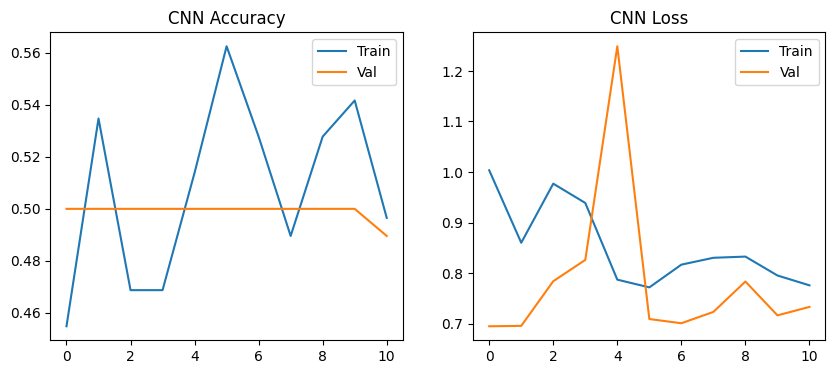

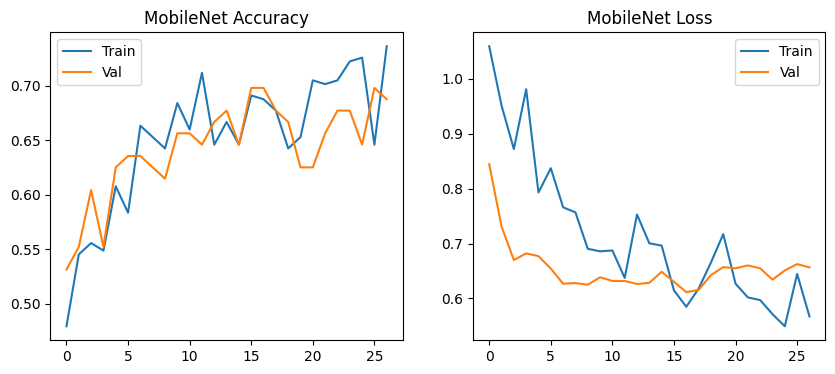

In [12]:
def plot_history(hist, title):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title(title + " Accuracy")
    plt.legend(["Train","Val"])

    plt.subplot(1,2,2)
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title(title + " Loss")
    plt.legend(["Train","Val"])
    plt.show()

plot_history(cnn_hist, "CNN")
plot_history(mb_hist, "MobileNet")


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step
              precision    recall  f1-score   support

      forged       0.61      0.79      0.69        48
     genuine       0.71      0.50      0.59        48

    accuracy                           0.65        96
   macro avg       0.66      0.65      0.64        96
weighted avg       0.66      0.65      0.64        96



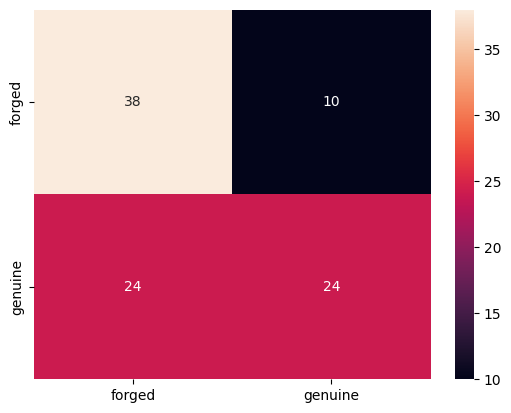

In [15]:
def evaluate(model):
    y_true = np.concatenate([y for _, y in test_ds])
    y_pred = (model.predict(test_ds) > 0.5).astype(int)

    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.show()

evaluate(mb_model)



In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def verify_signature_with_display(genuine_img, test_img, model, threshold=0.15):
    def _load_and_predict(img_path):
        img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
        arr = tf.keras.utils.img_to_array(img)
        arr = np.expand_dims(arr, 0)  # no manual normalization
        score = float(model.predict(arr, verbose=0)[0][0])
        return img, score

    g_img, g_score = _load_and_predict(genuine_img)
    t_img, t_score = _load_and_predict(test_img)

    diff = abs(g_score - t_score)
    is_match = diff < threshold

    result_text = "MATCH (Likely Genuine)" if is_match else "NOT MATCH (Likely Forged)"

    # ---- DISPLAY ----
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(g_img)
    plt.axis("off")
    plt.title(f"Genuine\nScore: {g_score:.4f}")

    plt.subplot(1, 2, 2)
    plt.imshow(t_img)
    plt.axis("off")
    plt.title(f"Test\nScore: {t_score:.4f}")

    plt.suptitle(
        f"{result_text}\nDifference: {diff:.4f} | Threshold: {threshold}",
        fontsize=12,
        fontweight="bold"
    )

    plt.tight_layout()
    plt.show()

    return {
        "genuine_score": g_score,
        "test_score": t_score,
        "difference": diff,
        "threshold": threshold,
        "result": result_text
    }


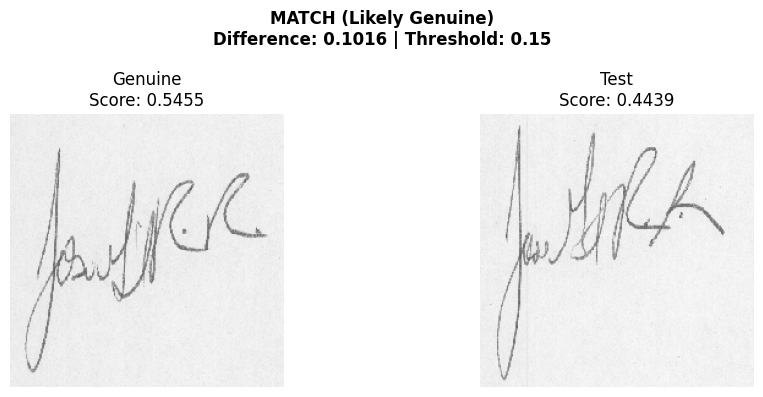

{'genuine_score': 0.5454815626144409,
 'test_score': 0.4438571035861969,
 'difference': 0.10162445902824402,
 'threshold': 0.15,
 'result': 'MATCH (Likely Genuine)'}

In [17]:
verify_signature_with_display(
    r"DataSet\full_org\original_3_16.png",
    r"DataSet\full_org\original_3_17.png",
    mb_model,
    threshold=0.15
)



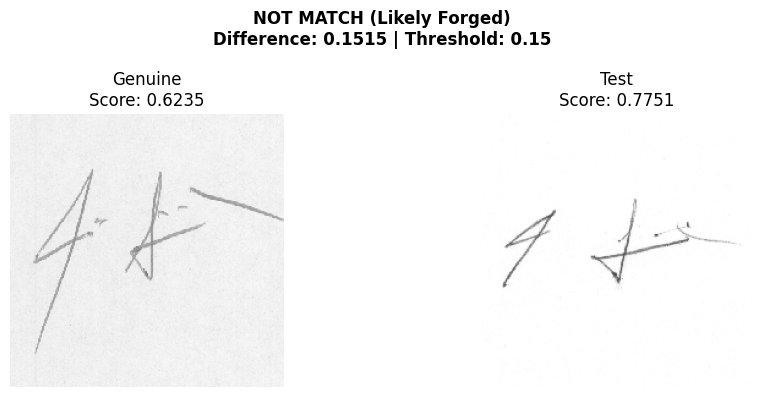

{'genuine_score': 0.6235277652740479,
 'test_score': 0.7750760316848755,
 'difference': 0.15154826641082764,
 'threshold': 0.15,
 'result': 'NOT MATCH (Likely Forged)'}

In [19]:
verify_signature_with_display(
    r"DataSet\full_org\original_1_1.png",
    r"DataSet\full_forg\forgeries_1_1.png",
    mb_model,
    threshold=0.15
)

Generating predictions for CNN Model...
Generating predictions for MobileNet Model...


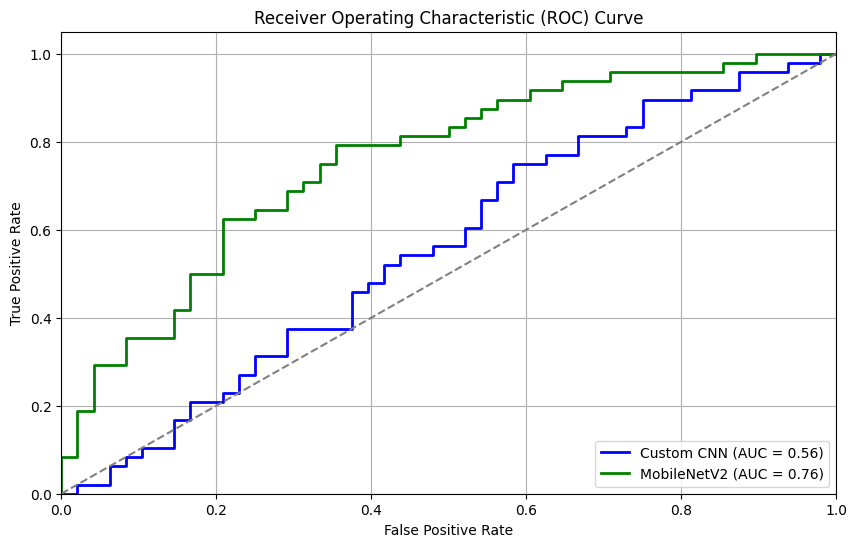

--- Custom CNN Metrics ---
FAR (False Acceptance Rate): 0.0000
FFR (False Forgery/Rejection Rate): 1.0000


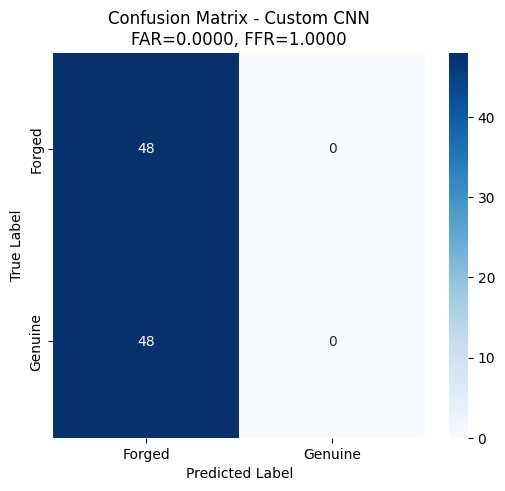

--- MobileNetV2 Metrics ---
FAR (False Acceptance Rate): 0.2083
FFR (False Forgery/Rejection Rate): 0.5000


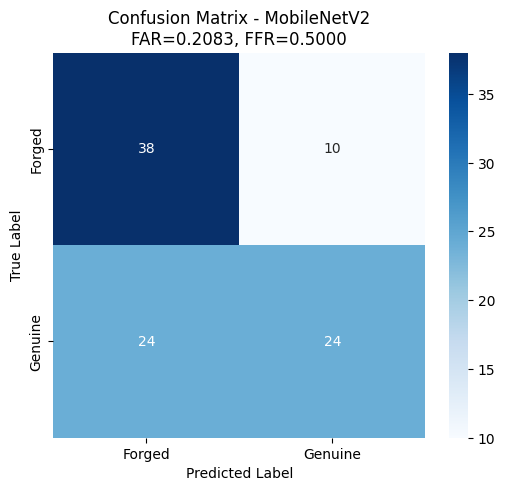

In [20]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def get_predictions(model, dataset):
    """
    Iterates over the dataset to get all true labels and predicted probabilities.
    """
    all_y_true = []
    all_y_pred = []
    
    for x, y in dataset:
        preds = model.predict(x, verbose=0)
        all_y_true.extend(y.numpy().flatten())
        all_y_pred.extend(preds.flatten())
        
    return np.array(all_y_true), np.array(all_y_pred)

# 1. Get Predictions for both models
print("Generating predictions for CNN Model...")
y_true, y_pred_cnn = get_predictions(cnn_model, test_ds)

print("Generating predictions for MobileNet Model...")
_, y_pred_mb = get_predictions(mb_model, test_ds)

# 2. Plot ROC Curves
fpr_cnn, tpr_cnn, _ = roc_curve(y_true, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

fpr_mb, tpr_mb, _ = roc_curve(y_true, y_pred_mb)
roc_auc_mb = auc(fpr_mb, tpr_mb)

plt.figure(figsize=(10, 6))
plt.plot(fpr_cnn, tpr_cnn, color='blue', lw=2, label=f'Custom CNN (AUC = {roc_auc_cnn:.2f})')
plt.plot(fpr_mb, tpr_mb, color='green', lw=2, label=f'MobileNetV2 (AUC = {roc_auc_mb:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 3. Confusion Matrices & FAR/FFR
def plot_metrics(y_true, y_pred, model_name):
    y_pred_classes = (y_pred > 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Calculate FAR and FFR
    # Assuming: 0 = Forged, 1 = Genuine
    # FAR (False Acceptance Rate): Forged (0) predicted as Genuine (1) -> FP / (TN + FP)
    # FFR (False Forgery/Rejection Rate): Genuine (1) predicted as Forged (0) -> FN / (TP + FN)
    
    tn, fp, fn, tp = cm.ravel()
    
    far = fp / (tn + fp) if (tn + fp) > 0 else 0
    ffr = fn / (tp + fn) if (tp + fn) > 0 else 0 # False Rejection Rate
    
    print(f"--- {model_name} Metrics ---")
    print(f"FAR (False Acceptance Rate): {far:.4f}")
    print(f"FFR (False Forgery/Rejection Rate): {ffr:.4f}")
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Forged', 'Genuine'], 
                yticklabels=['Forged', 'Genuine'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}\nFAR={far:.4f}, FFR={ffr:.4f}')
    plt.show()

plot_metrics(y_true, y_pred_cnn, "Custom CNN")
plot_metrics(y_true, y_pred_mb, "MobileNetV2")
